## Replicated Bayesian Model 
This notebook contains the replicated computational model of life-span prediction.

In [1]:
# setup the environment
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

### Model for a single observed value of current age

In [2]:
# observed current age (i.e., t value)
x = 60

# assuming that maximum possible age is 120 yrs
max_age = 120  

# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   


# Prior porabability distribution p(t_total)
p_theta = [(st.skewnorm.pdf(p, a=-4, loc=97, scale=28)) for p in thetas]  # prior probability: p(theta)
p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)

  
# likelihood function given observation that current age = x = 60    
likelihood = [1/p for p in thetas]  #  p(X/theta)
likelihood[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise


# computing normalizing factor for p(t) 
thetas = np.linspace(start=1, stop=max_age, num=max_age) 
sum_px = 0
for x_prime in np.arange(1, len(thetas)+1, 1):
    lik = [1/p for p in thetas]  #  p(X/theta)
    lik[0:x_prime-1] = [0]*(x_prime-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta, lik))
    sum_px += p_x

print "sum_px: ", sum_px   # this comes out to be 1 which is a good sign

# computing p(t)
p_x = np.sum(np.multiply(p_theta, likelihood)) 
p_x = p_x / sum_px   # normalizing, though in this case sum_px = 1


# Computing the posterior p(t_total/t)
posterior = np.multiply(p_theta, likelihood) / p_x  # p(theta/X) = likelihood * prior
posterior = posterior/np.sum(posterior)  # normalize posterior (to sum up to 1)


# compute the median of the posterior
median = 0
for a in np.arange(len(posterior)):
    cum = sum(posterior[:a+1])
    if cum == 0.5 or cum > 0.5:
        median = a + 1
        break

sum_px:  1.0


Prediction (median of the posterior distribution):  80


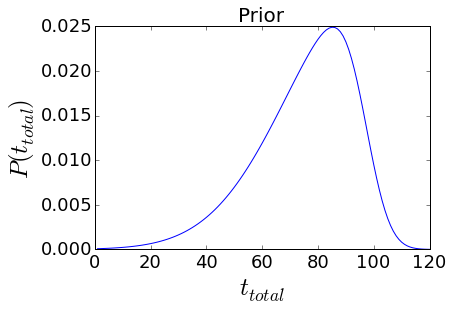

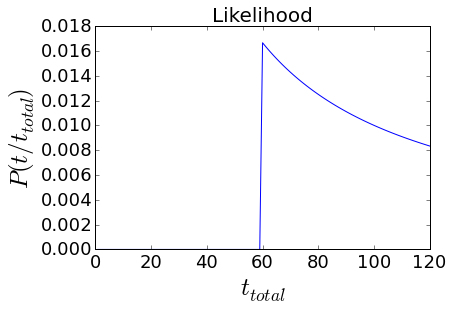

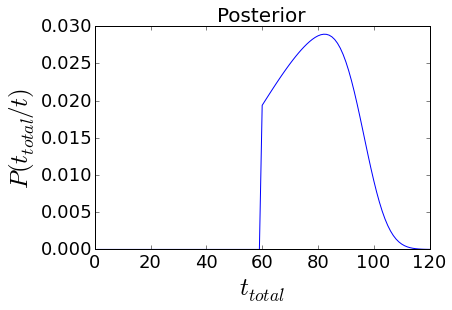

In [3]:
plt.figure()
plt.plot(thetas, p_theta)
plt.xlim(0,120)
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, likelihood)
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, posterior)
plt.title("Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

# prediction is the median of the posterior        
print "Prediction (median of the posterior distribution): ", median

### Predictions for all values of age from 1 to 100

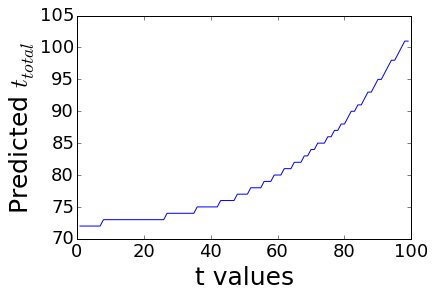

In [4]:
def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median

predictions = []
for x in np.arange(1,100,1):
    likelihood = [1/p for p in thetas]  #  p(X/theta)
    likelihood[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta, likelihood))       # already sums to 1
    posterior = np.multiply(p_theta, likelihood) / p_x   # already sums to 1
    #predictions.append(np.argmax(posterior) + 1) 
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions)
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
    
plt.show()    

### Empirical Bayes

Re-formulating the problem of life-span prediction as that of empirical bayes. The previous version of the model required an element-wise multiplication to compute the posterior. However, in this formulation, we first need to estimate the hyperparameter (alpha) for the prior, and then use that prior to compute the posterior. Computing the optimal alpha requires computing a computing a high-dimensional integral (matrix-matrix multiplication). It will be useful to see explore this type of integral can be computed using spiking neural networks, since these integrals are common in probabilistic computations.

alpha_hat:  97


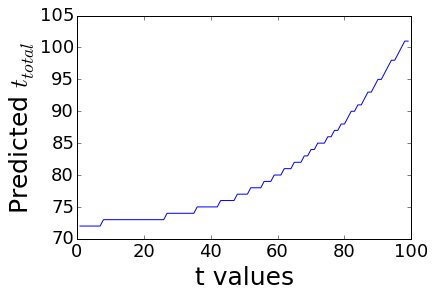

In [5]:
# assuming that maximum possible age is 120 yrs
max_age = 120


# observed values of current ages (i.e., t value)
# Here I am assuming that these are current ages of multiple people
# The goal is to estimate a prior distribution based on these ages
x_vector = [35, 5, 20, 55, 65, 72]


# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)

# likelihood function given the set of observations x1, x2, x3, x4, x5
# Since these are iid observations, likelihood is just the product of all
def cal_likelihood(x):
    like = np.asarray([1/p for p in thetas])   #  p(X/theta)
    like[0:x-1] = [0]*np.asarray(x-1)          # likelihood is 1/theta for theta >= x and 0 otherwise
    return like

likelihood = np.ones(max_age)
for i in x_vector:
    likelihood = np.multiply(likelihood, cal_likelihood(i))    
     

# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_matrix = np.zeros((len(thetas), max_age))
for x in np.arange(1,max_age+1,1):
    p_theta = [(st.skewnorm.pdf(p, a=-4, loc=x, scale=28)) for p in thetas]
    p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
    p_matrix[:, x-1] = p_theta
    

# Now compute p(X/alpha) by marginalizing out theta for each alpha
marginpost_set = np.dot(likelihood, p_matrix)   # this will be a list of dimentions (1 x max_age)
#pick the max value and find the corresponding alpha
alpha_hat = np.argmax(marginpost_set) + 1

print "alpha_hat: ", alpha_hat

# p(theta/alpha_hat): Note that I am considering loc parameter to be alpha (unknown)
# Assuming that a and scale parameters are known
p_theta_ga = [(st.skewnorm.pdf(p, a=-4, loc=alpha_hat, scale=28)) for p in thetas]
p_x = np.sum(np.multiply(p_theta_ga, likelihood)) 
posterior = np.multiply(p_theta_ga, likelihood) / p_x

def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median

predictions = []
for x in np.arange(1,100,1):
    like = [1/p for p in thetas]  #  p(X/theta)
    like[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta_ga, like))       # already sums to 1
    posterior = np.multiply(p_theta_ga, like) / p_x   # already sums to 1
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions)
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.show()